## Import Libraries

In [1]:
working_dir = "../."
# dataset_h5_path = r"C:\Users\andri\Progetti\lus-dl-framework\data\iclus\dataset.h5"
# hospitaldict_path = r"C:\Users\andri\Progetti\lus-dl-framework\data\iclus\hospitals-patients-dict.pkl"
dataset_h5_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/dataset.h5"
hospitaldict_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/hospitals-patients-dict.pkl"
libraries_dir = working_dir + "/libraries"

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
import pickle
import sys
import timm
from PIL import Image

import matplotlib.pyplot as plt
import torchvision 
import numpy as np
import pandas as pd
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from kornia import tensor_to_image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from lightning.pytorch.callbacks import EarlyStopping, DeviceStatsMonitor, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from torchsummary import summary
from collections import defaultdict
import timm



sys.path.append(working_dir)
from lightning_modules.LUSModelLightningModule import LUSModelLightningModule
from lightning_modules.LUSDataModule import LUSDataModule
from data_setup import HDF5Dataset, FrameTargetDataset, DataAugmentation, split_dataset, reduce_sets

os.chdir(working_dir)
os.getcwd()



'/Users/andry/Documents/GitHub/lus-dl-framework'

In [3]:
# Training settings
batch_size = 16
epochs = 20
lr = 1e-2
gamma = 0.7
rseed = 42
train_ratio = 0.6
num_workers = 0
trim_data = 0.15

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(rseed)

In [5]:
device = torch.device('mps')
device

device(type='mps')

## Load Data

In [6]:
dataset = HDF5Dataset(dataset_h5_path)

train_indices_path = os.path.dirname(dataset_h5_path) + f"/train_indices_{train_ratio}.pkl"
test_indices_path = os.path.dirname(dataset_h5_path) + f"/test_indices_{train_ratio}.pkl"

Serialized frame index map FOUND.

Loaded serialized data.


277 videos (58924 frames) loaded.


In [7]:
dataset = HDF5Dataset(dataset_h5_path)

train_indices = []
val_indices = []
test_indices = []

train_ratio = train_ratio
test_ratio = (1 - train_ratio)/2
val_ratio = test_ratio
ratios = [train_ratio, test_ratio, val_ratio]


def create_default_dict():
    return defaultdict(float)
def initialize_inner_defaultdict():
    return defaultdict(int)

print(f"Split ratios: {ratios}")
train_indices, val_indices, test_indices, split_info = split_dataset(
    rseed=rseed,
    dataset=dataset,
    pkl_file=hospitaldict_path,
    ratios=ratios)

# Create training and test subsets
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)  
val_subset = Subset(dataset, val_indices)  


if trim_data:
    train_indices_trimmed, val_indices_trimmed, test_indices_trimmed = reduce_sets(rseed,
                                                                                   train_subset,
                                                                                   val_subset,
                                                                                   test_subset,
                                                                                   trim_data)
    train_subset = Subset(dataset, train_indices_trimmed)
    test_subset = Subset(dataset, test_indices_trimmed)
    val_subset = Subset(dataset, val_indices_trimmed)

train_dataset = FrameTargetDataset(train_subset)
test_dataset = FrameTargetDataset(test_subset)
val_dataset = FrameTargetDataset(val_subset)
 
print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")    
print(f"Validation size: {len(val_dataset)}")    

lus_data_module = LUSDataModule(train_dataset, 
                                test_dataset,
                                val_dataset,
                                num_workers, 
                                batch_size)
# -------------------------------------------------------

Serialized frame index map FOUND.

Loaded serialized data.


277 videos (58924 frames) loaded.
Split ratios: [0.6, 0.2, 0.2]

Serialized splits found, loading ...

dataset reduction: 15% (train=5313, val=1757, test=1767)
Train size: 5313
Test size: 1767
Validation size: 1757


In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Retrieves the dataset's labels
ds_labels = split_info['labels']

# Extract the train and test set labels
y_train_labels = np.array(ds_labels)[train_indices]
y_test_labels = np.array(ds_labels)[test_indices]

# Calculate class balance using 'compute_class_weight'
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
weights_tensor = torch.Tensor(class_weights)
print("Class Weights: ", class_weights)

Class Weights:  [0.88899207 0.93380259 0.76457002 2.01484642]


## Dataloaders

/Users/andry/miniconda3/envs/lus_dl/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/Users/andry/miniconda3/envs/lus_dl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to we

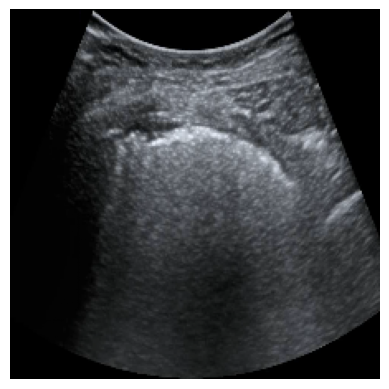

In [9]:
# Assuming train_dataset[0][0] contains the image data
image_tensor = train_dataset[0][0]

# Convert the image tensor to a NumPy array
image_array = image_tensor.permute(1, 2, 0).cpu().numpy()  # Assuming it's a GPU tensor

# Plot the image
plt.imshow(image_array)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

In [10]:
def collate_fn(examples):
    frames = torch.stack([example[0] for example in examples])  # Extract the preprocessed frames
    scores = torch.tensor([example[1] for example in examples])  # Extract the scores
    # return {"pixel_values": frames, "labels": scores}
    return (frames, scores)

train_dataloader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=0,
                          pin_memory=True,
                          collate_fn=collate_fn, shuffle=False)

test_dataloader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          pin_memory=True,
                          collate_fn=collate_fn)

## Batch Visualizations

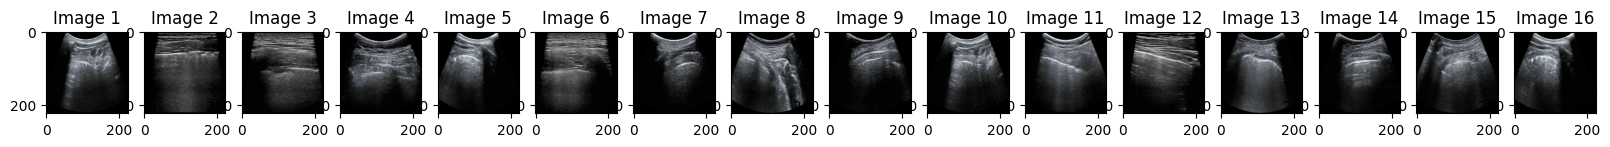

In [11]:
def show_single_batch(data_loader, batch_idx, win_size=(20, 20)):
    # Extract the specific batch by indexing the DataLoader
    for i, (imgs, labels) in enumerate(data_loader):
        if i == batch_idx:
            # Create a subplot for each image in the batch
            num_images = len(imgs)
            plt.figure(figsize=win_size)

            for j in range(num_images):
                plt.subplot(1, num_images, j + 1)
                plt.imshow(tensor_to_image(imgs[j]))  # Convert the tensor to an image
                plt.title(f"Image {j+1}")

            plt.show()
            break
# To display a specific batch (e.g., batch index 0) from the training DataLoader
show_single_batch(test_dataloader, batch_idx=6)

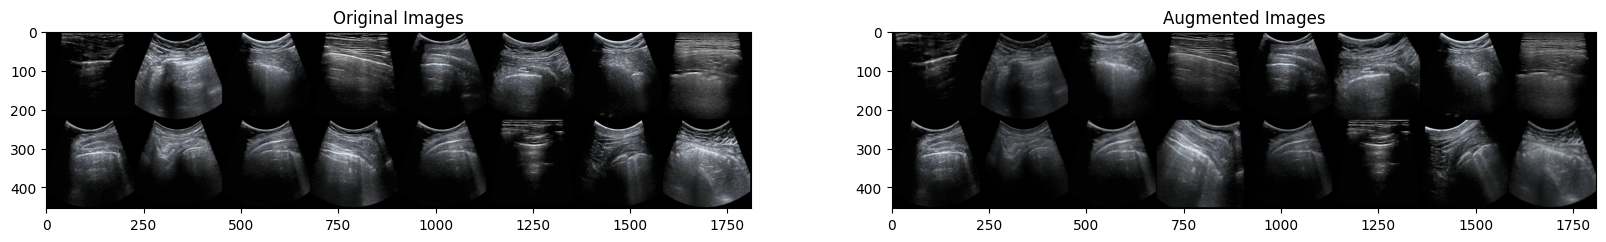

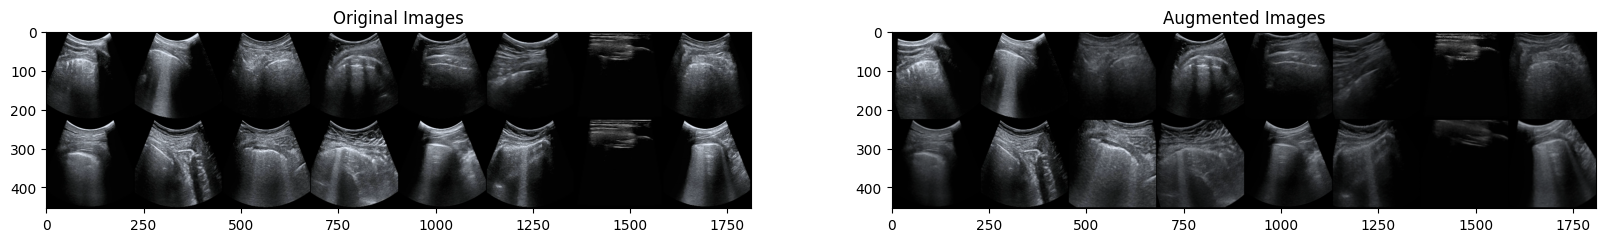

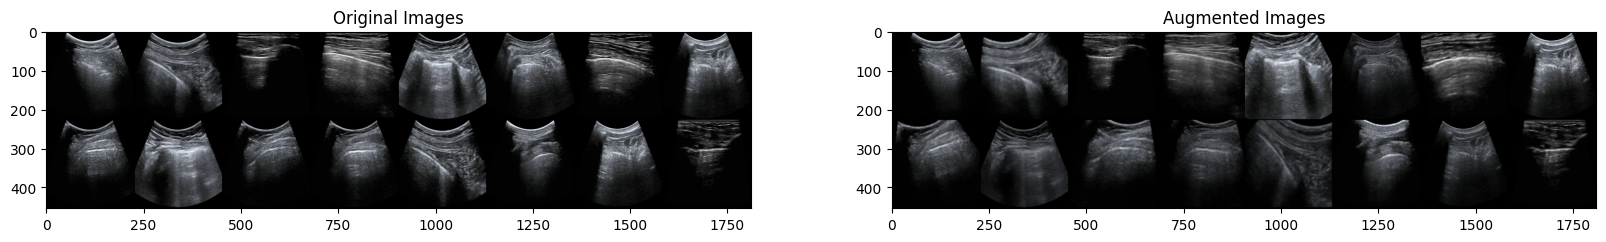

In [12]:
transform = DataAugmentation()   
def show_batch(data_loader, num_batches=1, win_size=(20, 20)):
    def _to_vis(data):
        # Ensure that pixel values are in the valid range [0, 1]
        data = torch.clamp(data, 0, 1)
        return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

    for batch_num, (imgs, labels) in enumerate(data_loader):
        if batch_num >= num_batches:
            break
        
        # Apply data augmentation to the batch (you need to define DataAugmentation function)
        imgs_aug = transform(imgs)

        # Create subplots for original and augmented images
        plt.figure(figsize=win_size)
        plt.subplot(1, 2, 1)
        plt.imshow(_to_vis(imgs))
        plt.title("Original Images")

        plt.subplot(1, 2, 2)
        plt.imshow(_to_vis(imgs_aug))
        plt.title("Augmented Images")

        plt.show()

# To display one batch from the training DataLoader
show_batch(test_dataloader, num_batches=3)

# Model

In [13]:
which_model = "vit"
pretrained = False
optimizer = "sgd"
lr = 0.0001
batch_size = 16
num_workers = 0
trimmed = 0.15


hyperparameters = {
  "num_classes": 4,
  "optimizer": "sgd",
  "lr": 0.001,
  "weight_decay": 0.0001,    
  "momentum": 0.9
#   "configuration": configuration
}
table_data = []
table_data.append(["MODEL HYPERPARAMETERS"])
table_data.append(["model", which_model])
for key, value in hyperparameters.items():
    if key not in ["train_dataset", "test_dataset"]:
      table_data.append([key, value])

table = tabulate(table_data, headers="firstrow", tablefmt="fancy_grid")
print(table)

╒══════════════╤═════════════════════════╕
│              │ MODEL HYPERPARAMETERS   │
╞══════════════╪═════════════════════════╡
│ model        │ vit                     │
├──────────────┼─────────────────────────┤
│ num_classes  │ 4                       │
├──────────────┼─────────────────────────┤
│ optimizer    │ sgd                     │
├──────────────┼─────────────────────────┤
│ lr           │ 0.001                   │
├──────────────┼─────────────────────────┤
│ weight_decay │ 0.0001                  │
├──────────────┼─────────────────────────┤
│ momentum     │ 0.9                     │
╘══════════════╧═════════════════════════╛


# Trainer

## Callbacks

In [14]:
# Callbacks
# -EarlyStopping
early_stop_callback = EarlyStopping(
    monitor='training_loss',
    patience=5,
    strict=False,
    verbose=False,
    mode='min'
)

# -Logger configuration
name_trained = "pretrained_" if pretrained==True else ""
model_name = f"{name_trained}{which_model}/{optimizer}/{lr}_{batch_size}"
logger = TensorBoardLogger("tb_logs", name=model_name)

# -Checkpointing
#   Checkpoints directory
checkpoint_dir = f"{working_dir}/checkpoints/{model_name}"
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_dir, 
                                      save_top_k=3,
                                      mode="min",
                                      monitor="training_loss",
                                      save_last=True,
                                      verbose=True)

callbacks = [
            # DeviceStatsMonitor(),
            LearningRateMonitor(),
            early_stop_callback,
            checkpoint_callback
            ]
checkpoint_dir

'.././checkpoints/vit/sgd/0.0001_16'

In [15]:
logger.log_dir

Missing logger folder: tb_logs/vit/sgd/0.0001_16


'tb_logs/vit/sgd/0.0001_16/version_0'

In [16]:
accelerator = "mps"
device = torch.device("mps")
max_epochs = 10
precision = 32
accumulate_grad_batches = 1

trainer_args = {
    "accelerator": accelerator,
    # "strategy": "ddp" if accelerator == "gpu" else "auto",
    "max_epochs": max_epochs,
    "callbacks": callbacks,
    "precision": precision,
    "accumulate_grad_batches": accumulate_grad_batches,
    "logger": logger
}

# Trainer 
trainer = Trainer(**trainer_args,
                #   detect_anomaly=True,
                #   overfit_batches=0.01,
                #   val_check_interval=0.25,
                #   gradient_clip_val=0.1,
                  default_root_dir = checkpoint_dir)

table_data = []
table_data.append(["TRAINER ARGUMENTS"])
for key, value in trainer_args.items():
    if key not in ["callbacks", "logger"]:
        table_data.append([key, value])

table = tabulate(table_data, headers="firstrow", tablefmt="fancy_grid")
print("\n\n" + table)
print(f"Model checkpoints directory is {checkpoint_dir}")
print("\n\n")

print("\n\n" + "-" * 20)
print("Trainer Callbacks:")
print("-" * 20 + "\n\n")
for callback in trainer.callbacks:
    print(f"- {type(callback).__name__}")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs




╒═════════════════════════╤═════════════════════╕
│                         │ TRAINER ARGUMENTS   │
╞═════════════════════════╪═════════════════════╡
│ accelerator             │ mps                 │
├─────────────────────────┼─────────────────────┤
│ max_epochs              │ 10                  │
├─────────────────────────┼─────────────────────┤
│ precision               │ 32                  │
├─────────────────────────┼─────────────────────┤
│ accumulate_grad_batches │ 1                   │
╘═════════════════════════╧═════════════════════╛
Model checkpoints directory is .././checkpoints/vit/sgd/0.0001_16





--------------------
Trainer Callbacks:
--------------------


- LearningRateMonitor
- EarlyStopping
- TQDMProgressBar
- ModelSummary
- ModelCheckpoint


## Checkpoints

In [17]:
def check_checkpoint(checkpoint_path):

    print("Checkpoint mode activated...\n")

    if (checkpoint_path == "best"):
        print("Loading BEST checkpoint...\n")

    if (checkpoint_path == "last"):
        print("Loading LAST checkpoint...\n")

    else:
    # Check if checkpoint file exists
        if not os.path.isfile(checkpoint_path):
            print(f"Checkpoint file '{checkpoint_path}' does not exist. Exiting...")
            exit()

    print(f"Loading checkpoint from PATH: '{checkpoint_path}'...\n")

# Evaluation

In [18]:
# timm.list_models('*swin*')

In [19]:
# model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False)
# model

### Select Model from checkpoint

In [20]:
# checkpoint_path = r"C:\Users\andri\Progetti\lus-dl-framework\checkpoints\pretrained_timm_bot\sgd\0.0001_32\epoch=2-step=951.ckpt"
# checkpoint_path = r"C:\Users\andri\Progetti\lus-dl-framework\checkpoints\pretrained_timm_bot\sgd\0.0001_32\epoch=29-step=37560.ckpt"
# checkpoint_path = r"C:\Users\andri\Progetti\lus-dl-framework\checkpoints\pretrained_timm_bot\sgd\5e-05_32\epoch=39-step=50080.ckpt"
# checkpoint_path = r"C:\Users\andri\Progetti\lus-dl-framework\checkpoints\trimmed_botnet18\sgd\ds_0.6_lr0.001_bs8\epoch=19-step=13920.ckpt"

# checkpoint_path = r"C:\Users\andri\Progetti\lus-dl-framework\checkpoints\trimmed_vit\sgd\ds_0.6_lr0.01_bs16\epoch=49-validation_loss=0.1290.ckpt"
# checkpoint_path = r"C:\Users\andri\Progetti\lus-dl-framework\checkpoints\trimmed_botnet18\sgd\ds_0.6_lr0.001_bs8\epoch=49-step=33250.ckpt"
# checkpoint_path = r"C:\Users\andri\Progetti\lus-dl-framework\checkpoints\trimmed_resnet18\sgd\ds_0.6_lr0.001_bs8\epoch=49-step=33250.ckpt"

# checkpoint_path = f"{os.getcwd()}/checkpoints/pretrained_layers.3_trimmed_swin_vit/adam/ds_0.6_lr0.001_bs8/epoch=0-validation_loss=0.8421.ckpt"
checkpoint_path = f"{os.getcwd()}/checkpoints/pretrained_mlp_trimmed_swin_vit/sgd/ds_0.6_lr0.001_bs16/epoch=10-validation_loss=0.3764.ckpt"

check_checkpoint(checkpoint_path)
model = LUSModelLightningModule.load_from_checkpoint(checkpoint_path, 
                                                     map_location=torch.device('mps'))
model.eval()

Checkpoint mode activated...

Loading checkpoint from PATH: '/Users/andry/Documents/GitHub/lus-dl-framework/checkpoints/pretrained_mlp_trimmed_swin_vit/sgd/ds_0.6_lr0.001_bs16/epoch=10-validation_loss=0.3764.ckpt'...



/Users/andry/miniconda3/envs/lus_dl/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.0, which is newer than your current Lightning version: v2.0.9.post0
  rank_zero_warn(
/Users/andry/miniconda3/envs/lus_dl/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



Using pretrained weights: True

Freezing all layers with {self.freeze_layers} in name
Parameter: patch_embed.proj.weight, Requires Gradient: True
Parameter: patch_embed.proj.bias, Requires Gradient: True
Parameter: patch_embed.norm.weight, Requires Gradient: True
Parameter: patch_embed.norm.bias, Requires Gradient: True
Parameter: layers.0.blocks.0.norm1.weight, Requires Gradient: True
Parameter: layers.0.blocks.0.norm1.bias, Requires Gradient: True
Parameter: layers.0.blocks.0.attn.relative_position_bias_table, Requires Gradient: True
Parameter: layers.0.blocks.0.attn.qkv.weight, Requires Gradient: True
Parameter: layers.0.blocks.0.attn.qkv.bias, Requires Gradient: True
Parameter: layers.0.blocks.0.attn.proj.weight, Requires Gradient: True
Parameter: layers.0.blocks.0.attn.proj.bias, Requires Gradient: True
Parameter: layers.0.blocks.0.norm2.weight, Requires Gradient: True
Parameter: layers.0.blocks.0.norm2.bias, Requires Gradient: True
Parameter: layers.0.blocks.0.mlp.fc1.weight, Re

LUSModelLightningModule(
  (train_criterion): CrossEntropyLoss()
  (test_criterion): CrossEntropyLoss()
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True

In [21]:
# Freeze all layers except the head
# for name, param in model.named_parameters():
#     if 'head' in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
# freeze_up_to_layer = ""

freeze = True
freeze_up_to_layer = "layers.3"
for name, param in model.named_parameters():
    if freeze_up_to_layer in name:
        freeze = False
    if freeze:
        param.requires_grad = False


# Verify which layers are frozen and which are trainable
for name, param in model.named_parameters():
    print(f'Parameter: {name}, Requires Gradient: {param.requires_grad}')

# for name, param in model.named_parameters():
#     if not param.requires_grad:
#         print(f'Parameter: {name}, Requires Gradient: {param.requires_grad}')


Parameter: model.patch_embed.proj.weight, Requires Gradient: False
Parameter: model.patch_embed.proj.bias, Requires Gradient: False
Parameter: model.patch_embed.norm.weight, Requires Gradient: False
Parameter: model.patch_embed.norm.bias, Requires Gradient: False
Parameter: model.layers.0.blocks.0.norm1.weight, Requires Gradient: False
Parameter: model.layers.0.blocks.0.norm1.bias, Requires Gradient: False
Parameter: model.layers.0.blocks.0.attn.relative_position_bias_table, Requires Gradient: False
Parameter: model.layers.0.blocks.0.attn.qkv.weight, Requires Gradient: False
Parameter: model.layers.0.blocks.0.attn.qkv.bias, Requires Gradient: False
Parameter: model.layers.0.blocks.0.attn.proj.weight, Requires Gradient: False
Parameter: model.layers.0.blocks.0.attn.proj.bias, Requires Gradient: False
Parameter: model.layers.0.blocks.0.norm2.weight, Requires Gradient: False
Parameter: model.layers.0.blocks.0.norm2.bias, Requires Gradient: False
Parameter: model.layers.0.blocks.0.mlp.fc1.

In [22]:
# Display some checkpoint information
print("Checkpoint Information:")
print(f"Checkpoint Path: {checkpoint_path}")
print(f"Hyperparameters: {model.hparams}")
print(f"Trained on Device: {model.device}")

# You can access and print more specific information as needed
# For example, model hyperparameters, optimizer state, etc.

# Access model's state_dict (model weights)
model_state_dict = model.state_dict()
print("Model State Dictionary:")
print(model_state_dict)


Checkpoint Information:
Checkpoint Path: /Users/andry/Documents/GitHub/lus-dl-framework/checkpoints/pretrained_mlp_trimmed_swin_vit/sgd/ds_0.6_lr0.001_bs16/epoch=10-validation_loss=0.3764.ckpt
Hyperparameters: "class_weights": tensor([1.1124, 0.8109, 0.7017, 2.2589], device='mps:0')
"freeze_layers": mlp
"hparams":       {'num_classes': 4, 'optimizer': 'sgd', 'lr': 0.001, 'weight_decay': 0.0001, 'momentum': 0.9}
"model_name":    swin_vit
"pretrained":    True
Trained on Device: mps:0
Model State Dictionary:
OrderedDict([('train_criterion.weight', tensor([1.1124, 0.8109, 0.7017, 2.2589], device='mps:0')), ('model.patch_embed.proj.weight', tensor([[[[ 1.1094e-02,  2.2433e-02, -2.3866e-02, -4.3722e-02],
          [ 1.3767e-02,  6.2052e-02,  2.4950e-02,  5.5948e-02],
          [-2.2271e-02,  1.8835e-02,  2.2541e-02, -7.0543e-03],
          [-5.7405e-02, -4.1724e-02, -4.9328e-02, -2.8436e-02]],

         [[-2.5268e-02,  8.2404e-04, -6.1033e-02, -6.8698e-02],
          [ 1.4657e-02,  8.2772e-

## CAM

### Attention Rollout

In [23]:
from vit_explain.vit_grad_rollout import VITAttentionGradRollout

In [24]:
model.cpu()
grad_rollout = VITAttentionGradRollout(model, discard_ratio=0.9)

In [25]:
# Load the image tensor
image_idx = 500
input_tensor = test_dataset[image_idx][0].unsqueeze(0).cpu()
input_label = test_dataset[image_idx][1]

print(f"Input tensor shape: {input_tensor.shape}")
print(f"Input label: {input_label}")

Input tensor shape: torch.Size([1, 3, 224, 224])
Input label: 3


In [26]:
mask = grad_rollout(input_tensor,
                    category_index=input_label)

/Users/andry/miniconda3/envs/lus_dl/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


RuntimeError: The size of tensor a (4) must match the size of tensor b (32) at non-singleton dimension 1

### Select the layer

In [27]:
# Alternatively, you can use named_modules to include nested sub-modules.
for name, module in model.named_modules():
    print(name)


patch_embed
patch_embed.proj
patch_embed.norm
layers
layers.0
layers.0.downsample
layers.0.blocks
layers.0.blocks.0
layers.0.blocks.0.norm1
layers.0.blocks.0.attn
layers.0.blocks.0.attn.qkv
layers.0.blocks.0.attn.attn_drop
layers.0.blocks.0.attn.proj
layers.0.blocks.0.attn.proj_drop
layers.0.blocks.0.attn.softmax
layers.0.blocks.0.drop_path1
layers.0.blocks.0.norm2
layers.0.blocks.0.mlp
layers.0.blocks.0.mlp.fc1
layers.0.blocks.0.mlp.act
layers.0.blocks.0.mlp.drop1
layers.0.blocks.0.mlp.norm
layers.0.blocks.0.mlp.fc2
layers.0.blocks.0.mlp.drop2
layers.0.blocks.0.drop_path2
layers.0.blocks.1
layers.0.blocks.1.norm1
layers.0.blocks.1.attn
layers.0.blocks.1.attn.qkv
layers.0.blocks.1.attn.attn_drop
layers.0.blocks.1.attn.proj
layers.0.blocks.1.attn.proj_drop
layers.0.blocks.1.attn.softmax
layers.0.blocks.1.drop_path1
layers.0.blocks.1.norm2
layers.0.blocks.1.mlp
layers.0.blocks.1.mlp.fc1
layers.0.blocks.1.mlp.act
layers.0.blocks.1.mlp.drop1
layers.0.blocks.1.mlp.norm
layers.0.blocks.1.ml

### Get CAMs

Idx: 800, Target: 2, Predicted: 2


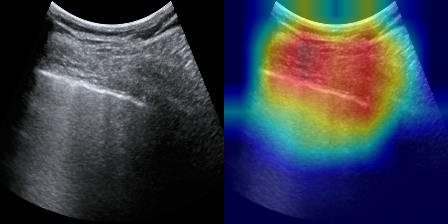

In [28]:
from pytorch_grad_cam import GradCAMPlusPlus, ScoreCAM, AblationCAM, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
import cv2
import PIL

# ViT
# def reshape_transform(tensor, height=14, width=14):
#     result = tensor[:, 1 :  , :].reshape(tensor.size(0),
#         height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result


#SwinViT
def swin_reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def generate_and_display_CAM(image, cam_model, target_layers, cam_method="gradcamplusplus", target_class=None):
    
    if cam_method == "scorecam":
        cam = ScoreCAM(model=cam_model, target_layers=target_layers)
    elif cam_method == "ablationcam":
        cam = AblationCAM(model=cam_model, target_layers=target_layers)
    else:
        cam = GradCAMPlusPlus(model=cam_model, 
                              target_layers=target_layers, 
                              reshape_transform=swin_reshape_transform)
    
    
    # Prepare the input tensor
    input_tensor = image.unsqueeze(0)
    targets = None
    if target_class is not None:
        targets=[ClassifierOutputTarget(target_class)]

    # targets = [0, 1, 2, 3]
    # Generate CAM
    grayscale_cams = cam(input_tensor=input_tensor, 
                        #  aug_smooth=True,
                         eigen_smooth=True,
                         targets=targets)
    
    # Convert the input tensor to a numpy image
    img = np.float32(transforms.ToPILImage()(image)) / 255
    # Show CAM on the image
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    
    # Convert CAM to BGR format for display
    cam = np.uint8(255 * grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    
    # Display the original image and the associated CAM
    images = np.hstack((np.uint8(255 * img), cam_image))
    return Image.fromarray(images)


# Load the image tensor
image_idx = 800
image = test_dataset[image_idx][0]

# Class to target
target_class = None

cam_method = "gradcamplusplus"
# cam_method = "scorecam"
# cam_method = "ablationcam"


# Specify the target layer for CAM
target_layers = [model.model.layers[-1].blocks[-1].norm2]
# target_layers = [model.model.layer4[-2]]
# target_layers = [model.model.layer3]
# target_layers = [model.model.transformer.layers[5][0].dropout]

        
if cam_method == "scorecam":
    image = image.to("cpu")
    model = model.to("cpu")
else:
    image = image.to(device)
    model = model.to(device)

# Usage
displayed_image = generate_and_display_CAM(image, model, target_layers, target_class=target_class, cam_method=cam_method)
print(f"Idx: {image_idx}, Target: {test_dataset[image_idx][1]}, Predicted: {model(image.unsqueeze(0))[0].argmax()}")
displayed_image

In [57]:
len(test_dataset)

1767

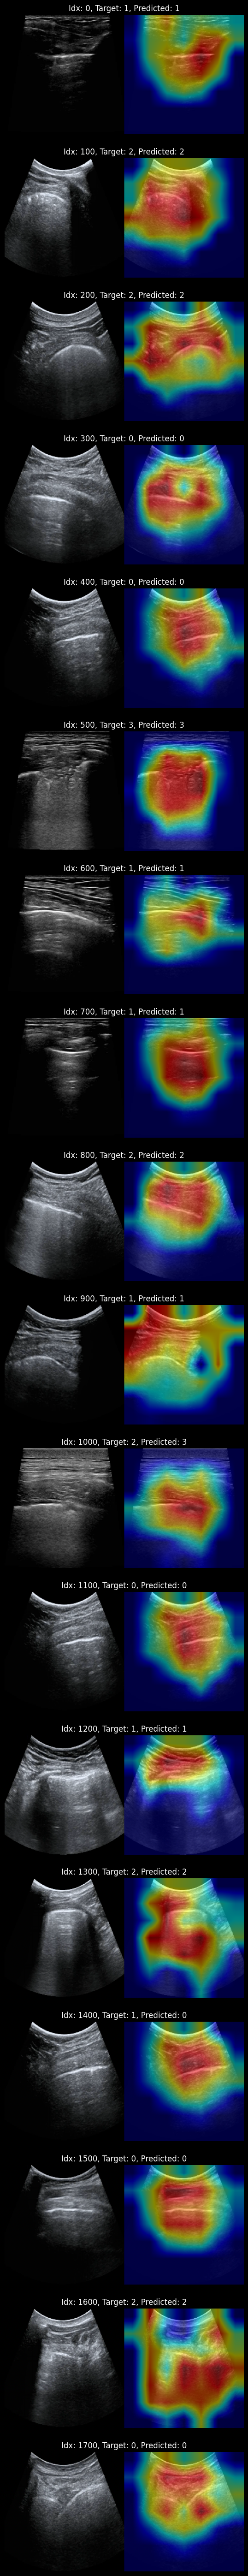

In [29]:
# List of image indices you want to display
image_indices_to_plot = list(range(0, len(test_dataset), 100))
# Class to target
target_class = None

cam_method = "gradcamplusplus"
# cam_method = "scorecam"
# cam_method = "ablationcam"


# Specify the target layers for CAM
target_layers = [model.model.layers[-1].blocks[-1].norm2]
# target_layers = [model.model.layer4[-1]]
# target_layers = [model.model.layer[1]]
# target_layers = [model.model.transformer.layers[5][0].dropout]



if cam_method == "scorecam":
    image = image.to("cpu")
    model = model.to("cpu")
else:
    image = image.to(device)
    model = model.to(device)


# Create subplots for the selected images with a larger figsize
# num_maps = activation_maps.size(1)  # Get the total number of activation maps
num_rows = len(image_indices_to_plot)  # Calculate the number of rows needed
num_images = len(image_indices_to_plot)
fig, axes = plt.subplots(num_rows, 1, figsize=(20, 4 * num_rows))  # Adjust the figsize as per your preference

for i, image_idx in enumerate(image_indices_to_plot):
    image = test_dataset[image_idx][0].to(device)
    displayed_image = generate_and_display_CAM(image, model, target_layers, cam_method=cam_method, target_class=target_class)
    
    axes[i].imshow(displayed_image)
    axes[i].set_title(f"Idx: {image_idx}, Target: {test_dataset[image_idx][1]}, Predicted: {model(image.unsqueeze(0))[0].argmax()}")
    axes[i].axis('off')
plt.show()



### TorchCAM

In [140]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image

cam_extractor = SmoothGradCAMpp(model)

In [153]:
activation_map[0].shape

torch.Size([1, 197, 64])

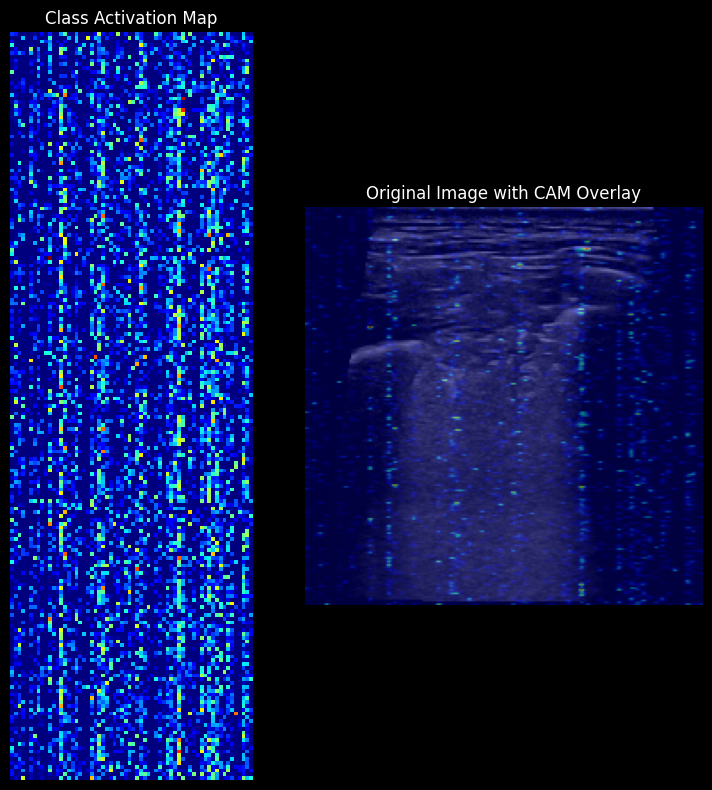

In [145]:
# Load the image tensor
image_idx = 500
input_tensor = test_dataset[image_idx][0]
out = model(input_tensor.unsqueeze(0))
class_idx = out.argmax().item()


activation_map = cam_extractor(class_idx, out)
# activation_map = attns[0][5][15]

# Visualize the raw CAM
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(activation_map[0].squeeze(0).cpu().numpy(), cmap='jet')
plt.title('Class Activation Map')
plt.axis('off')

# Load the original image
img = transforms.ToPILImage()(input_tensor.cpu())

# Resize the CAM and overlay it
result = overlay_mask(img, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Display the original image with overlay
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title('Original Image with CAM Overlay')
plt.axis('off')

plt.tight_layout()
# print(f"Idx: {image_idx}, Target: {test_dataset[image_idx][1]}, Predicted: {model(image.unsqueeze(0))[0].argmax()}")
plt.show()


## Model viz Export

In [60]:
model.to(device)
model.eval()

LUSModelLightningModule(
  (model): BotNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [63]:
from torch.utils.tensorboard import SummaryWriter

for param in model.parameters():
    param.requires_grad = True
    
image_idx = 100
writer = SummaryWriter(f"C:/Users/andri/Progetti/lus-dl-framework/tb_logs/trimmed_botnet18/sgd/ds_0.6_lr0.001_bs8/v1")
# writer = SummaryWriter('tb_logs\\pretrained_timm_bot/sgd/5e-05_32\\version_2')
input_tensor = test_dataset[image_idx][0].unsqueeze(0).to(device)
input_tensor.requires_grad = True

model.trainer = trainer
writer.add_graph(model, input_tensor)
writer.close()

c:\Users\andri\anaconda3\envs\lus_dl\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
c:\Users\andri\anaconda3\envs\lus_dl\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(ant

In [ ]:
image_idx = 5000
in_size = test_dataset[image_idx][0].unsqueeze(0).shape
in_size

In [33]:
from torchview import draw_graph
from torch import nn
import torch
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


In [35]:
model_graph_1 = draw_graph(
    model, input_size=in_size,
    graph_name='BoTNet',
    # roll=True,
    # hide_inner_tensors=False,
    # hide_module_functions=False,
    depth=5,
    expand_nested=True,
    graph_attrs={'fontsize': '18'},  # Set the graph font size
    node_attrs={'fontsize': '16'}   
)

RuntimeError: Failed to run torchgraph see error message


(dot.exe:12336): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


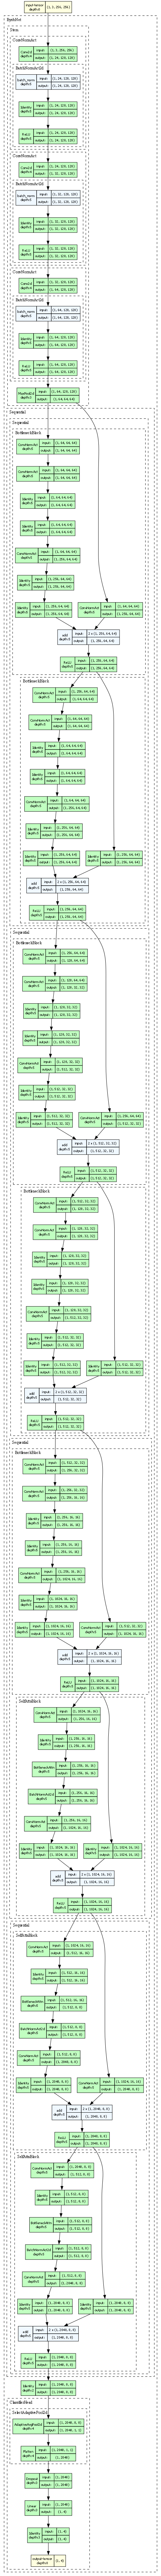

In [115]:
model_graph_1.visual_graph

# TEST

In [ ]:

image_idx = 1000
image = test_dataset[image_idx][0].to(device).unsqueeze(0)
with torch.no_grad():
    features = model(image)

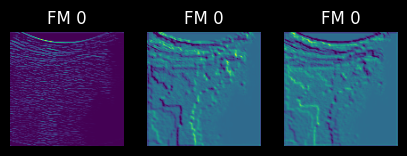

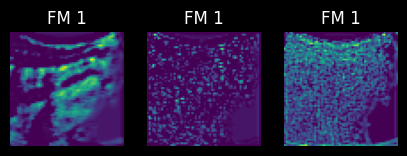

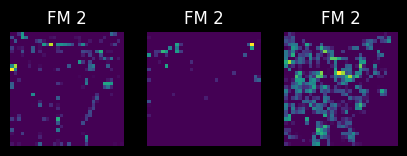

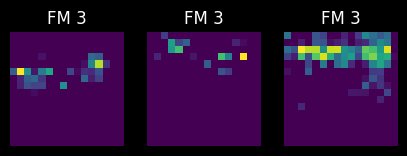

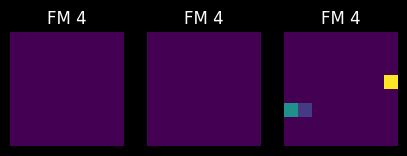

actual: 2


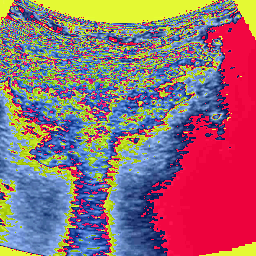

In [ ]:
image_idx = 1000

image = Image.fromarray(test_dataset[image_idx][0])

transformed_image = transforms(image)

image = torch_transforms.ToTensor()(test_dataset[image_idx][0])
image = torch_transforms.Resize((256, 256))(image)



input_img = transformed_image
pil_input = torch_transforms.ToPILImage()(input_img)

output = model(input_img.unsqueeze(0))
# Iterate through the output feature maps
for i, o in enumerate(output):
    # Assuming 'o' has shape [1, channels, height, width]

    # Convert the tensor to a NumPy array
    feature_map = o[0].cpu().detach().numpy()

    # You may want to normalize the feature map to [0, 1] for visualization
    feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
    plt.figure(figsize=(5, 5))
    # Create the first subplot
    plt.subplot(1, 3, 1)
    plt.imshow(feature_map[0], cmap='viridis')
    plt.title(f'FM {i}')
    plt.axis('off')

    # Create the second subplot
    plt.subplot(1, 3, 2)
    plt.imshow(feature_map[1], cmap='viridis')
    plt.title(f'FM {i}')
    plt.axis('off')

    # Create the third subplot
    plt.subplot(1, 3, 3)
    plt.imshow(feature_map[2], cmap='viridis')
    plt.title(f'FM {i}')
    plt.axis('off')

plt.show()
    
    
# print(f"predicted: {output.argmax(dim=1)}")
print(f"actual: {test_dataset[image_idx][1]}")
pil_input

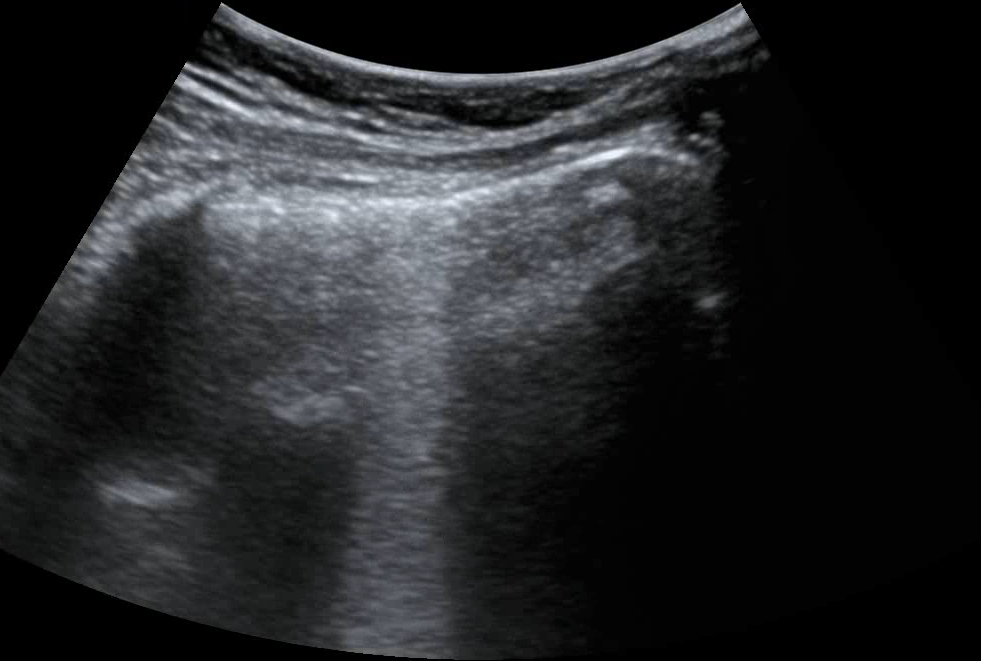

In [40]:
image

In [42]:
top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=4)
top5_probabilities, top5_class_indices

(tensor([[32.4556, 24.2118, 22.1401, 21.1925]], grad_fn=<TopkBackward0>),
 tensor([[0, 3, 2, 1]]))

### Training

In [ ]:
model.to(device)

ByobNet(
  (stem): Stem(
    (conv1): ConvNormAct(
      (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv2): ConvNormAct(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_dataloader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_dataloader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_dataloader)
            epoch_val_loss += val_loss / len(test_dataloader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/2448 [00:00<?, ?it/s]

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray